In [50]:
import os
import glob
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms.functional as TF
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [53]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
      super().__init__()
      self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
         )

    def forward(self, x):
        return self.double_conv(x)

In [54]:
class UNET(nn.Module):
     def __init__(self, in_channels=3, out_channels=1, features=[64,128,256,512]):
         super().__init__()
         self.ups = nn.ModuleList()
         self.downs = nn.ModuleList()
         self.pool = nn.MaxPool2d(kernel_size=2,stride=2)

         for feature in features:
             self.downs.append(DoubleConv(in_channels,feature))
             in_channels = feature

         for feature in reversed(features):
             self.ups.append(nn.ConvTranspose2d(feature*2,feature,kernel_size=2,stride=2))
             self.ups.append(DoubleConv(feature*2,feature))
             
         self.bottleneck = DoubleConv(features[-1],features[-1]*2)
         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

     def forward(self,x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.Resize(x , size=skip_connection[2:])
            concats = torch.cat((x,skip_connection), dim=1)
            x = self.ups[idx+1](concats)
        return self.final_conv(x)

In [55]:
img_dir = '/kaggle/input/carvana-image-masking-png/train_images'
mask_dir = '/kaggle/input/carvana-image-masking-png/train_masks'

img_paths = sorted(glob.glob(os.path.join(img_dir,'*.jpg')))
mask_paths = sorted(glob.glob(os.path.join(mask_dir,'*.png')))

assert len(img_paths) == len(mask_paths), 'No Match'

# Splitting Data
train_img, test_img, train_mask, test_mask = train_test_split( img_paths, mask_paths, train_size=0.8, random_state=7)



# Transforms with sneaky [] inside ()
train_transforms = T.Compose([ T.ToTensor(), # must come first 
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) 
test_transforms = T.Compose([ T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]) 



In [56]:
class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None, resize_size=(256, 256)):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.resize_size = resize_size
        
    def __len__(self):
        return len(self.img_paths) 
        
    def __getitem__(self, index): # Load PIL images 
        image = Image.open(self.img_paths[index]).convert('RGB') 
        mask = Image.open(self.mask_paths[index]).convert('L') 
        
        # Resize both 
        image = image.resize(self.resize_size, Image.BILINEAR) 
        mask = mask.resize(self.resize_size, Image.NEAREST) 
        
        # Apply transforms to image only 
        if self.transform:
          image = self.transform(image)
          mask = np.array(mask, dtype=np.float32) # Convert PIL to array of shape (H, W)
          mask[mask == 255.0] = 1.0 # Seperate foreground and background
          mask = torch.from_numpy(mask).long().unsqueeze(0) # shape (1, H, W) PyTorch expects segmentation masks to have a channel dimension, just like images have (C, H, W).For a binary mask, C = 1.
        return image, mask

In [57]:
train_dataset = CustomDataset(train_img, train_mask, transform=train_transforms)
test_dataset = CustomDataset(test_img, test_mask, transform=test_transforms)

# Dataloaders 
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.5179958].


Image batch: torch.Size([4, 3, 256, 256])
Mask batch: torch.Size([4, 1, 256, 256])


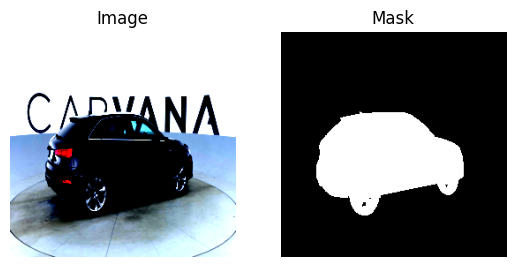

In [58]:
for img, mask in train_loader:
    print("Image batch:", img.shape) # [B, 3, H, W] 
    print("Mask batch:", mask.shape) # [B, 1, H, W] 
    plt.subplot(1, 2, 1) 
    plt.imshow(img[0].permute(1, 2, 0).cpu()) 
    plt.title("Image") 
    plt.axis("off")
    
    plt.subplot(1, 2, 2) 
    plt.imshow(mask[0,0].cpu(), cmap="gray") 
    plt.title("Mask") 
    plt.axis("off") 
    plt.show()
    # optional: break if you only want the first batch
    break

In [59]:
def DiceLoss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)  # flattening to convert (B,c,256,256) into B*C*256*256 Flattening ensures we’re comparing every pixel in the batch as part of one big set, instead of trying to compute Dice per dimension.
    target = target.view(-1)
    intersection = (pred*target).sum()
    dice_score = (2*intersection+smooth)/(pred.sum()+target.sum()+smooth)
    return 1-dice_score

def DiceScore(pred, target, smooth=1e-6):
    pred =(pred>0.5).float()
    target = target.float()
    intersection = (pred*target).sum()
    dice_score = (2*intersection+smooth)/(pred.sum()+target.sum()+smooth)
    return dice_score

In [60]:
model = UNET()  # Sneaky () here 
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=1e-6)

In [64]:
epochs = 3
train_losses=[]
test_losses=[]
train_dice=[]
test_dice=[]
 

for epoch in range(epochs):
    dice_score_trains = 0 # bahira rakh yeslai 
    loss_trains = 0
    model.train()
    for img,mask in train_loader:
        img,mask = img.to(device), mask.to(device).float()
        output = model(img)

        # Calculate loss
        dice_loss = DiceLoss(output, mask)
        bce_loss = criterion(output, mask)
        loss = dice_loss+bce_loss

        # Back prop
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Sneaky _ here & it prevents exploding gradients
        optimizer.step()
        
        # Dice score after back prop to minimize computational cost
        probs = torch.sigmoid(output)
        dice_score_train = DiceScore(probs, mask)
        
        dice_score_trains +=  dice_score_train.item()
        loss_trains += loss.item()
        
    avg_dice_train = dice_score_trains/len(train_loader)
    avg_train_loss = loss_trains/len(train_loader)

    # Evaluating Loop
    dice_score_tests = 0 
    loss_tests = 0
    model.eval()
    with torch.no_grad(): # grads haina muji
        for img,mask in test_loader:
            img,mask = img.to(device), mask.to(device).float()  # Mask floating for BCE Loss
            output = model(img)

            # Calculate loss
            dice_loss = DiceLoss(output, mask)
            bce_loss = criterion(output, mask)
            loss = dice_loss+bce_loss

            probs = torch.sigmoid(output)
            dice_score_test = DiceScore(probs, mask)
            dice_score_tests +=  dice_score_test.item()
            loss_tests += loss.item()
        
    avg_dice_test = dice_score_tests/len(test_loader) # Align with with.torch.no_grad()
    avg_test_loss = loss_tests/len(test_loader)

    scheduler.step()

    # Only for graphhing
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_dice.append(avg_dice_train)
    test_dice.append(avg_dice_test)


    # for printing
    print(f'epoch:{epoch+1}')
    print(f"  Train - Loss: {avg_train_loss:.4f}, Dice: {avg_dice_train:.4f}")
    print(f"  Val   - Loss: {avg_test_loss:.4f}, Dice: {avg_dice_test:.4f}")


epoch:1
  Train - Loss: 0.1857, Dice: 0.9859
  Val   - Loss: 0.0887, Dice: 0.9873
epoch:2
  Train - Loss: 0.0585, Dice: 0.9913
  Val   - Loss: 0.1551, Dice: 0.9581
epoch:3
  Train - Loss: 0.0357, Dice: 0.9933
  Val   - Loss: 0.0326, Dice: 0.9934


<function matplotlib.pyplot.show(close=None, block=None)>

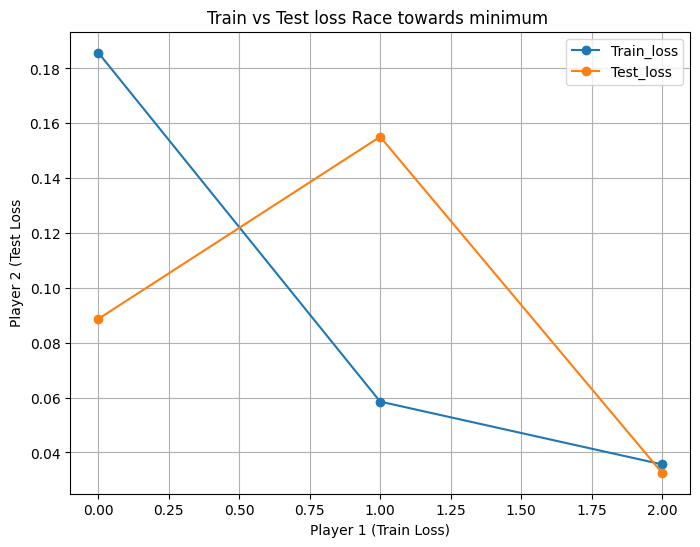

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train_loss', marker='o')
plt.plot(test_losses, label ='Test_loss', marker='o')
plt.title('Train vs Test loss Race towards minimum ')
plt.xlabel('Player 1 (Train Loss)')
plt.ylabel('Player 2 (Test Loss')
plt.grid(True)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

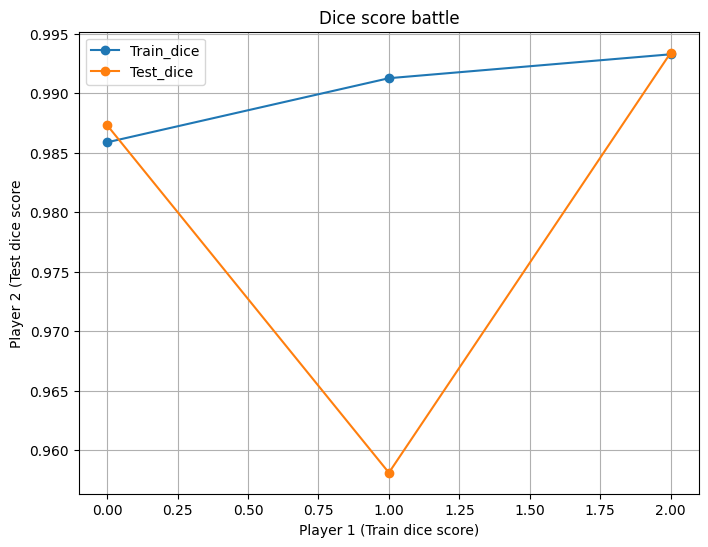

In [66]:
plt.figure(figsize=(8,6))
plt.plot(train_dice, label='Train_dice', marker='o')
plt.plot(test_dice, label ='Test_dice', marker='o')
plt.title('Dice score battle')
plt.xlabel('Player 1 (Train dice score)')
plt.ylabel('Player 2 (Test dice score')
plt.grid(True)
plt.legend()
plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.6051416].


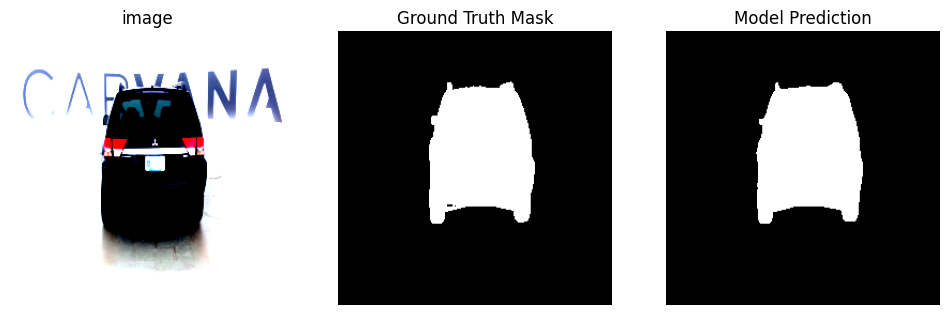

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


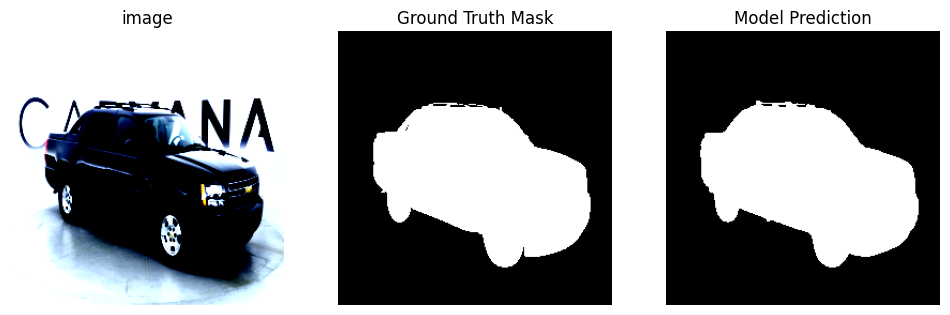

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


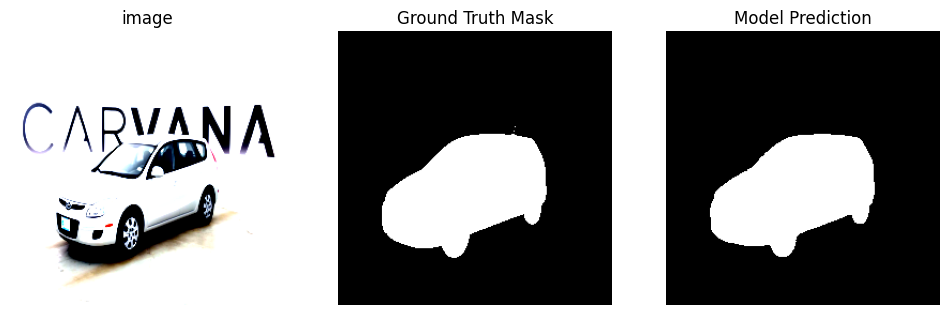

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].


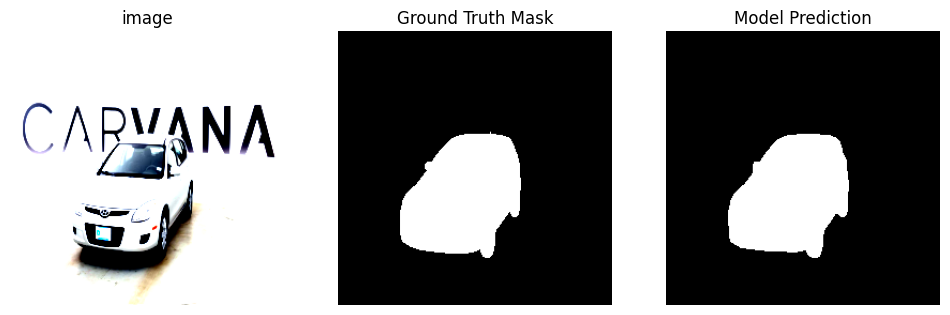

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.6051416].


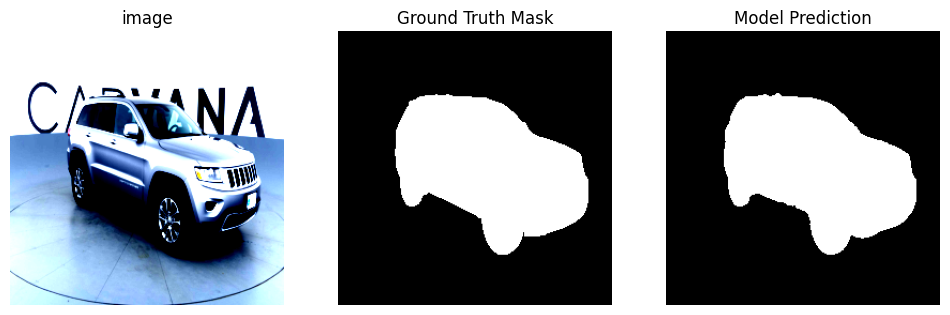

In [75]:
num_images = 5
model.eval()
with torch.no_grad():
    for i, (img,msk) in enumerate(test_loader):
        if i>= num_images:
            break

        img,msk = img.to(device), msk.to(device).float()

        # Algorithm
        output = model(img)
        probs = torch.sigmoid(output)
        preds = (probs>0.5).float()

        # Convert tensor to cpu numpy
        image = img[0].permute(1,2,0).cpu().numpy() # Shape goes from [B, C, H, W] → [C, H, W]. Then you do permute to reorder it into [H, W, C] for Matplotlib.
        mask = msk[0,0].cpu().numpy() # [H,W]=[0,0]
        pred = preds[0,0].cpu().numpy()

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.imshow(image)
        plt.title('image')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(1,3,3)
        plt.imshow(pred, cmap="gray")
        plt.title("Model Prediction")
        plt.axis("off")
        
        plt.show()

# Looks like, My model with transposed conv overkilled carbana dataset. 🎯✅
# Carbana CustomDataset you didnt offer test set so i need to split you.
# Good bye carbana Babe!😭💔

# Key takeaways from today:
1. Use CosineAnnealingLR scheduler helps a lot.
2. torch.nn.utils.clip_grad_norm_ removes graident vanishing problems.
3. Dont ever augmment on test set.